In [25]:
import sys
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import json
import shapely
from shapely.geometry import Polygon, Point, shape, box, mapping, MultiPolygon
from shapely.affinity import translate
from shapely.ops import transform
from pyproj import Transformer
from datetime import datetime, timedelta
import glob
import importlib.util
import osgeo as gdal
import rasterio

sys.path.insert(1, "src")
from putils import save_svg, get_observation, plot_geometry, plot_matrix, validate_geom
from futils import forward_pass_farsite, forward_pass_farsite_24h, cleanup_farsite_outputs
from dautils import sample_winddirection, sample_windspeed, adjusted_state_EnKF_farsite, geom_to_state, state_to_geom, align_states, interpolate_geom, interpolate_geoms

In [2]:
%load_ext autoreload 
%autoreload 2

# FARSITE input parameters
- Perimeter polygon (ESPG 5070)
- Landscape layers (LCP file format)

In [3]:
# Static input parameters - fixed throughout the 
LCPPATH = "landscape.lcp"
TIMEDELTA = pd.Timedelta(hours=24) 
DIST_RES = 150
PERIM_RES = 150

# Print for sanity check
print("LCP path:", LCPPATH)
print("Timedelta:", TIMEDELTA)
print("Distance resolution:", DIST_RES)
print("Perimeter resolution:", PERIM_RES)

LCP path: landscape.lcp
Timedelta: 1 days 00:00:00
Distance resolution: 150
Perimeter resolution: 150


In [4]:
# Read ignition data
poly_filepath = "outputs/border2_polygon.geojson"
with open(poly_filepath) as f:
    gj = json.load(f)


# Save initial polygon as Shapely object
feature = gj["features"][0]
INITIAL_POLY = shape(feature["geometry"])

# Read ignition data file
ignition_file = "outputs/border2_ignition.geojson"
with open(ignition_file) as f:
    ignition_json = json.load(f)


# Read incident identifiers
INCIDENT_NAME = ignition_json["properties"]["incident_name"]
IRWIN_ID = ignition_json["properties"]["irwin_id"]


# Print for sanity check
print("Incident name:", INCIDENT_NAME)
print("IRWIN ID:", IRWIN_ID)
print("Initial polygon:", INITIAL_POLY)

Incident name: BORDER 2
IRWIN ID: 386ebecf-af18-442d-b5d9-e2772b91914a
Initial polygon: POLYGON ((-117.012489 32.45592, -116.668957 32.45592, -116.668957 32.74584, -117.012489 32.74584, -117.012489 32.45592))


In [5]:
# Dynamic input parameters at t0 - changes with each timestep
t = 0
START_TIME = ignition_json["properties"]["ignition_time"]
END_TIME = ignition_json["properties"]["wX_end_time"]
WIND_SPEED_LIST = ignition_json["properties"]["wind_speed_list"]
WIND_DIRECTION_LIST = ignition_json["properties"]["wind_direction_list"]

# Print for sanity check
print("Start time:", START_TIME)
print("End time:",END_TIME)
print("Wind speed:", WIND_SPEED_LIST)
print("Wind direction:",WIND_DIRECTION_LIST)

Start time: 2025-01-23T13:53:00
End time: 2025-01-24T13:53:00
Wind speed: [4.47, 15.2, 11.62, 9.84, 11.17, 9.84, 9.84, 7.6, 8.94, 12.52, 12.52, 12.52, 11.62, 11.62, 9.84, 11.62, 10.28, 11.17, 13.86, 13.86, 10.28, 5.81, 6.26, 6.26]
Wind direction: [57.0, 80.0, 84.0, 85.0, 84.0, 81.0, 82.0, 77.0, 78.0, 84.0, 79.0, 81.0, 86.0, 81.0, 88.0, 93.0, 106.0, 107.0, 90.0, 90.0, 90.0, 88.0, 102.0, 114.0]


In [6]:
# Transform inputs for FARSITE

# Convert polygon to EPSG 5070
transformer = Transformer.from_crs("EPSG:4326", "EPSG:5070", always_xy=True)
INITIAL_POLY = transform(transformer.transform, INITIAL_POLY)


# Standardize IRWIN ID string
IRWIN_ID = str(IRWIN_ID).strip("{}").replace("-", "_").lower()


# Reformat start and end time strings from ISO format to %Y-%m-%d %H:%M:%S
START_TIME = datetime.strptime(START_TIME, "%Y-%m-%dT%H:%M:%S").strftime("%Y-%m-%d %H:%M:%S")
END_TIME = datetime.strptime(END_TIME, "%Y-%m-%dT%H:%M:%S").strftime("%Y-%m-%d %H:%M:%S")


# Define params dictionary
params = {'windspeed': WIND_SPEED_LIST[0],'winddirection': WIND_DIRECTION_LIST[0],'dt': TIMEDELTA}


# Print for sanity check
print("Initial polygon:", INITIAL_POLY)
print("IRWIN ID:", IRWIN_ID)
print("Start time:", START_TIME)
print("End time:",END_TIME)
print("Params", params)

Initial polygon: POLYGON ((-1948859.4466053003 1258934.5916586877, -1917505.9107450177 1251946.3934898481, -1910528.5525217545 1283519.9450767816, -1941768.0001541798 1290482.7148171153, -1948859.4466053003 1258934.5916586877))
IRWIN ID: 386ebecf_af18_442d_b5d9_e2772b91914a
Start time: 2025-01-23 13:53:00
End time: 2025-01-24 13:53:00
Params {'windspeed': 4.47, 'winddirection': 57.0, 'dt': Timedelta('1 days 00:00:00')}


## Read in sorted perimeter update records for data assimilation later

In [38]:
PERIMETER_UPDATES_GDF = gpd.read_file("outputs/border2_perimeters_sorted.geojson")

# make sure order is preserved
if "update_rank" in PERIMETER_UPDATES_GDF.columns:
    PERIMETER_UPDATES_GDF = PERIMETER_UPDATES_GDF.sort_values("update_rank").reset_index(drop=True)

PERIMETER_UPDATES_GDF

,attr_IrwinID,attr_FORID,attr_ContainmentDateTime,attr_FireDiscoveryDateTime,attr_CreatedOnDateTime_dt,attr_ModifiedOnDateTime_dt,poly_CreateDate,poly_GISAcres,poly_Acres_AutoCalc,Shape__Area,geometry
0,NaN,{6B163292-F2FA-4FB5-98BD-138BCDD8F877},1738116000000,1737669180000,1737669553000,1739117987310,None,6629.88,6629.853012,0.002578,"MULTIPOLYGON (((-116.873 32.64, -116.873 32.64..."
1,NaN,{6B163292-F2FA-4FB5-98BD-138BCDD8F877},1738116000000,1737669180000,1737669553000,1739117987310,None,6629.88,6629.853012,0.002578,"MULTIPOLYGON (((-116.873 32.64, -116.873 32.64..."
2,NaN,{6B163292-F2FA-4FB5-98BD-138BCDD8F877},1738116000000,1737669180000,1737669553000,1739117987310,None,6624.77,6605.542068,0.002568,"MULTIPOLYGON (((-116.86 32.651, -116.86 32.651..."
3,{386EBECF-AF18-442D-B5D9-E2772B91914A},NaN,1738116000000,1737669494000,1737669553210,1769045528603,None,6629.88,6629.853012,0.002568,"MULTIPOLYGON (((-116.86 32.651, -116.86 32.651..."


# Forward Pass (FARSITE) at t=0

In [17]:
%reload_ext autoreload

In [18]:
t0_output = forward_pass_farsite_24h(
    poly=INITIAL_POLY, 
    params=params, 
    start_time=START_TIME, 
    lcppath=LCPPATH, 
    irwinid=IRWIN_ID, 
    dist_res=DIST_RES, 
    perim_res=PERIM_RES
)

1 days 00:00:00 steps remaining.
0 days 23:30:00 steps remaining.
0 days 23:00:00 steps remaining.
0 days 22:30:00 steps remaining.
0 days 22:00:00 steps remaining.
0 days 21:30:00 steps remaining.
0 days 21:00:00 steps remaining.
0 days 20:30:00 steps remaining.
0 days 20:00:00 steps remaining.
0 days 19:30:00 steps remaining.
0 days 19:00:00 steps remaining.
0 days 18:30:00 steps remaining.
0 days 18:00:00 steps remaining.
0 days 17:30:00 steps remaining.
/home/jovyan/work/WIFIRE-Digital-Twinners/dt-refactored/386ebecf_af18_442d_b5d9_e2772b91914a_out_31adc95458a54162b233e9511724ea8a_Perimeters.shp does not exist.
farsite output geometry is None. Returning last valid geometry.


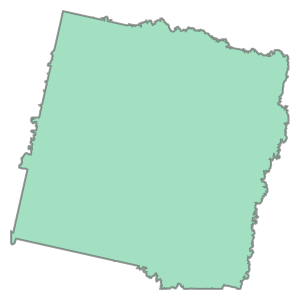

In [20]:
t0_output

In [11]:
OUTPUT_PATH = "outputs/border2_t0_prediction.geojson"


## Data Assimilation (EnKF) at t=0
EnKF input parameters:
- initial state
- observed state
- observation time
- covariance matrix
- number of vertices
- number of samples
- number of states
- number of outputs
- random number generator
- wind speed sample
- wind direction sample
- timedelta
- distance resolution
- perimeter resolution

## Define EnKF parameters and run t=0

In [39]:
# Prediction states
t1_initial_state = geom_to_state(t0_output)  # Convert output of t=0 to state (numpy array)
t1_observation_state = geom_to_state(PERIMETER_UPDATES_GDF['geometry'][0])
t1_obs_time = pd.Timestamp(END_TIME).to_pydatetime()

# Align prediction and observed states
n_vertex = t1_initial_state.shape[0] // 2
t1_observation_state, t1_initial_state = align_states([t1_observation_state, t1_initial_state], vertex_count=n_vertex)

# State parameters
n_samples = min(300, 5 * n_vertex)
n_states = 2 * n_vertex
n_output = n_states

# Weather observations
rng = np.random.Generator(np.random.PCG64(1234))
idx = rng.integers(0, len(WIND_SPEED_LIST), size=n_samples)
sampled_wslst = np.asarray(WIND_SPEED_LIST)[idx]
sampled_wdlst = np.asarray(WIND_DIRECTION_LIST)[idx]

# Input parameters
X = 1e3 * np.eye(n_states)
dt = pd.Timedelta(minutes=30)
dist_res = 150
perim_res = 150
vsize=500  # Observation uncertainty
wsize=200   # Model uncertainty

# Forward Pass & Data Assimilation at t>0

In [ ]:
res = adjusted_state_EnKF_farsite(initial_state=t1_initial_state, observation_state=t1_observation_state, observation_time=t1_obs_time,
                        X=X, n_states=n_states, n_output=n_output, n_vertex=n_vertex, n_samples=n_samples, rng=rng, 
                        sampled_wslst=sampled_wslst, sampled_wdlst=sampled_wdlst, dt=TIMEDELTA,
                        vsize=vsize, wsize=wsize, irwinid=IRWIN_ID, dist_res=dist_res, perim_res=perim_res)

init bounds: (-1948994.0, 1251826.0, -1910385.018444464, 1290471.9791580879)
obs bounds: (-116.91509082721363, 32.58456560772466, -116.8378300921635, 32.649430996786464)


  0%|          | 0/300 [00:00<?, ?it/s]

[{'windspeed': 6, 'winddirection': 114, 'dt': Timedelta('0 days 00:30:00')}, '2025-01-24 13:53:00', 'landscape.lcp', '386ebecf_af18_442d_b5d9_e2772b91914a', 150, 150]
forward bounds: (-1948993.0, 1251825.0, -1910416.0, 1290509.0)


  0%|          | 1/300 [00:48<3:59:34, 48.08s/it]

[{'windspeed': 6, 'winddirection': 114, 'dt': Timedelta('0 days 00:30:00')}, '2025-01-24 13:53:00', 'landscape.lcp', '386ebecf_af18_442d_b5d9_e2772b91914a', 150, 150]


  1%|          | 2/300 [01:24<3:23:22, 40.95s/it]

forward bounds: (-1948994.0, 1251826.0, -1910417.0, 1290503.0)
[{'windspeed': 6, 'winddirection': 114, 'dt': Timedelta('0 days 00:30:00')}, '2025-01-24 13:53:00', 'landscape.lcp', '386ebecf_af18_442d_b5d9_e2772b91914a', 150, 150]
forward bounds: (-1948993.0, 1251825.0, -1910385.0, 1290459.0)


  1%|          | 3/300 [01:46<2:41:17, 32.58s/it]

[{'windspeed': 12, 'winddirection': 84, 'dt': Timedelta('0 days 00:30:00')}, '2025-01-24 13:53:00', 'landscape.lcp', '386ebecf_af18_442d_b5d9_e2772b91914a', 150, 150]


  1%|▏         | 4/300 [02:11<2:24:49, 29.35s/it]

forward bounds: (-1948994.0, 1251825.0, -1910385.0, 1290469.0)
[{'windspeed': 11, 'winddirection': 84, 'dt': Timedelta('0 days 00:30:00')}, '2025-01-24 13:53:00', 'landscape.lcp', '386ebecf_af18_442d_b5d9_e2772b91914a', 150, 150]
forward bounds: (-1948994.0, 1251825.0, -1910385.0, 1290502.0)


  2%|▏         | 5/300 [02:42<2:27:10, 29.93s/it]

[{'windspeed': 6, 'winddirection': 102, 'dt': Timedelta('0 days 00:30:00')}, '2025-01-24 13:53:00', 'landscape.lcp', '386ebecf_af18_442d_b5d9_e2772b91914a', 150, 150]
forward bounds: (-1948993.0, 1251825.0, -1910422.0, 1290474.0)


  2%|▏         | 6/300 [03:26<2:50:23, 34.77s/it]

[{'windspeed': 11, 'winddirection': 84, 'dt': Timedelta('0 days 00:30:00')}, '2025-01-24 13:53:00', 'landscape.lcp', '386ebecf_af18_442d_b5d9_e2772b91914a', 150, 150]
/home/jovyan/work/WIFIRE-Digital-Twinners/dt-refactored/386ebecf_af18_442d_b5d9_e2772b91914a_out_6c97c7df7d6d4a92ba89be05973bc701_Perimeters.shp does not exist.
farsite output geometry is None


  2%|▏         | 7/300 [08:28<9:57:20, 122.32s/it]

[{'windspeed': 9, 'winddirection': 82, 'dt': Timedelta('0 days 00:30:00')}, '2025-01-24 13:53:00', 'landscape.lcp', '386ebecf_af18_442d_b5d9_e2772b91914a', 150, 150]


  3%|▎         | 8/300 [08:55<7:26:37, 91.77s/it] 

forward bounds: (-1948994.0, 1251825.0, -1910385.0, 1290480.0)
[{'windspeed': 9, 'winddirection': 85, 'dt': Timedelta('0 days 00:30:00')}, '2025-01-24 13:53:00', 'landscape.lcp', '386ebecf_af18_442d_b5d9_e2772b91914a', 150, 150]


  3%|▎         | 9/300 [09:22<5:47:32, 71.66s/it]

forward bounds: (-1948993.0, 1251825.0, -1910385.0, 1290534.0)
[{'windspeed': 7, 'winddirection': 77, 'dt': Timedelta('0 days 00:30:00')}, '2025-01-24 13:53:00', 'landscape.lcp', '386ebecf_af18_442d_b5d9_e2772b91914a', 150, 150]
forward bounds: (-1948994.0, 1251825.0, -1910385.0, 1290478.0)


  3%|▎         | 10/300 [09:46<4:34:55, 56.88s/it]

[{'windspeed': 11, 'winddirection': 86, 'dt': Timedelta('0 days 00:30:00')}, '2025-01-24 13:53:00', 'landscape.lcp', '386ebecf_af18_442d_b5d9_e2772b91914a', 150, 150]


  4%|▎         | 11/300 [10:13<3:50:27, 47.84s/it]

forward bounds: (-1948993.0, 1251825.0, -1910385.0, 1290484.0)
[{'windspeed': 11, 'winddirection': 84, 'dt': Timedelta('0 days 00:30:00')}, '2025-01-24 13:53:00', 'landscape.lcp', '386ebecf_af18_442d_b5d9_e2772b91914a', 150, 150]


  4%|▍         | 12/300 [10:36<3:13:38, 40.34s/it]

forward bounds: (-1929759.0, 1288372.0, -1929150.0, 1288774.0)
[{'windspeed': 13, 'winddirection': 90, 'dt': Timedelta('0 days 00:30:00')}, '2025-01-24 13:53:00', 'landscape.lcp', '386ebecf_af18_442d_b5d9_e2772b91914a', 150, 150]


  4%|▍         | 13/300 [11:05<2:55:19, 36.65s/it]

forward bounds: (-1948993.0, 1251825.0, -1910385.0, 1290488.0)
[{'windspeed': 9, 'winddirection': 81, 'dt': Timedelta('0 days 00:30:00')}, '2025-01-24 13:53:00', 'landscape.lcp', '386ebecf_af18_442d_b5d9_e2772b91914a', 150, 150]


  5%|▍         | 14/300 [11:31<2:40:26, 33.66s/it]

forward bounds: (-1948994.0, 1251825.0, -1910385.0, 1290490.0)
[{'windspeed': 13, 'winddirection': 90, 'dt': Timedelta('0 days 00:30:00')}, '2025-01-24 13:53:00', 'landscape.lcp', '386ebecf_af18_442d_b5d9_e2772b91914a', 150, 150]


  5%|▌         | 15/300 [11:58<2:30:12, 31.62s/it]

forward bounds: (-1948994.0, 1251825.0, -1910385.0, 1290485.0)
[{'windspeed': 7, 'winddirection': 77, 'dt': Timedelta('0 days 00:30:00')}, '2025-01-24 13:53:00', 'landscape.lcp', '386ebecf_af18_442d_b5d9_e2772b91914a', 150, 150]
forward bounds: (-1948988.0, 1251825.0, -1910437.0, 1290485.0)


  5%|▌         | 16/300 [12:43<2:48:21, 35.57s/it]

[{'windspeed': 13, 'winddirection': 90, 'dt': Timedelta('0 days 00:30:00')}, '2025-01-24 13:53:00', 'landscape.lcp', '386ebecf_af18_442d_b5d9_e2772b91914a', 150, 150]


  6%|▌         | 17/300 [13:11<2:37:10, 33.32s/it]

forward bounds: (-1948992.0, 1251825.0, -1910385.0, 1290490.0)
[{'windspeed': 6, 'winddirection': 114, 'dt': Timedelta('0 days 00:30:00')}, '2025-01-24 13:53:00', 'landscape.lcp', '386ebecf_af18_442d_b5d9_e2772b91914a', 150, 150]


  6%|▌         | 18/300 [13:36<2:25:17, 30.91s/it]

forward bounds: (-1948994.0, 1251825.0, -1910385.0, 1290496.0)
[{'windspeed': 6, 'winddirection': 102, 'dt': Timedelta('0 days 00:30:00')}, '2025-01-24 13:53:00', 'landscape.lcp', '386ebecf_af18_442d_b5d9_e2772b91914a', 150, 150]
forward bounds: (-1948994.0, 1251825.0, -1910386.0, 1290482.0)


  6%|▋         | 19/300 [14:23<2:47:10, 35.70s/it]

[{'windspeed': 9, 'winddirection': 82, 'dt': Timedelta('0 days 00:30:00')}, '2025-01-24 13:53:00', 'landscape.lcp', '386ebecf_af18_442d_b5d9_e2772b91914a', 150, 150]
forward bounds: (-1948987.0, 1251825.0, -1910436.0, 1290459.0)


  7%|▋         | 20/300 [14:51<2:35:13, 33.26s/it]

[{'windspeed': 11, 'winddirection': 81, 'dt': Timedelta('0 days 00:30:00')}, '2025-01-24 13:53:00', 'landscape.lcp', '386ebecf_af18_442d_b5d9_e2772b91914a', 150, 150]
/home/jovyan/work/WIFIRE-Digital-Twinners/dt-refactored/386ebecf_af18_442d_b5d9_e2772b91914a_out_7bf8437899f14e8db9ec58fdf4f77800_Perimeters.shp does not exist.
farsite output geometry is None


  7%|▋         | 21/300 [19:54<8:51:11, 114.24s/it]

[{'windspeed': 12, 'winddirection': 79, 'dt': Timedelta('0 days 00:30:00')}, '2025-01-24 13:53:00', 'landscape.lcp', '386ebecf_af18_442d_b5d9_e2772b91914a', 150, 150]
forward bounds: (-1948993.0, 1251845.0, -1910468.0, 1290538.0)


  7%|▋         | 22/300 [21:14<8:01:22, 103.90s/it]

[{'windspeed': 9, 'winddirection': 82, 'dt': Timedelta('0 days 00:30:00')}, '2025-01-24 13:53:00', 'landscape.lcp', '386ebecf_af18_442d_b5d9_e2772b91914a', 150, 150]
forward bounds: (-1948994.0, 1251825.0, -1910385.0, 1290487.0)


  8%|▊         | 23/300 [21:41<6:14:06, 81.04s/it] 

[{'windspeed': 9, 'winddirection': 88, 'dt': Timedelta('0 days 00:30:00')}, '2025-01-24 13:53:00', 'landscape.lcp', '386ebecf_af18_442d_b5d9_e2772b91914a', 150, 150]
forward bounds: (-1948992.0, 1251825.0, -1910385.0, 1290467.0)


  8%|▊         | 24/300 [22:11<5:01:31, 65.55s/it]

[{'windspeed': 5, 'winddirection': 88, 'dt': Timedelta('0 days 00:30:00')}, '2025-01-24 13:53:00', 'landscape.lcp', '386ebecf_af18_442d_b5d9_e2772b91914a', 150, 150]


  8%|▊         | 25/300 [22:39<4:08:35, 54.24s/it]

forward bounds: (-1948981.0, 1251825.0, -1910386.0, 1290503.0)
[{'windspeed': 10, 'winddirection': 90, 'dt': Timedelta('0 days 00:30:00')}, '2025-01-24 13:53:00', 'landscape.lcp', '386ebecf_af18_442d_b5d9_e2772b91914a', 150, 150]


  9%|▊         | 26/300 [23:09<3:34:44, 47.02s/it]

forward bounds: (-1948991.0, 1251825.0, -1910385.0, 1290520.0)
[{'windspeed': 11, 'winddirection': 93, 'dt': Timedelta('0 days 00:30:00')}, '2025-01-24 13:53:00', 'landscape.lcp', '386ebecf_af18_442d_b5d9_e2772b91914a', 150, 150]


  9%|▉         | 27/300 [23:29<2:57:35, 39.03s/it]

forward bounds: (-1914354.0, 1265693.0, -1913392.0, 1266292.0)
[{'windspeed': 10, 'winddirection': 90, 'dt': Timedelta('0 days 00:30:00')}, '2025-01-24 13:53:00', 'landscape.lcp', '386ebecf_af18_442d_b5d9_e2772b91914a', 150, 150]


  9%|▉         | 28/300 [23:57<2:42:17, 35.80s/it]

forward bounds: (-1948994.0, 1251825.0, -1910385.0, 1290503.0)
[{'windspeed': 11, 'winddirection': 86, 'dt': Timedelta('0 days 00:30:00')}, '2025-01-24 13:53:00', 'landscape.lcp', '386ebecf_af18_442d_b5d9_e2772b91914a', 150, 150]
/home/jovyan/work/WIFIRE-Digital-Twinners/dt-refactored/386ebecf_af18_442d_b5d9_e2772b91914a_out_8b935ec5891b429784c2f71a1c5b3967_Perimeters.shp does not exist.
farsite output geometry is None


 10%|▉         | 29/300 [29:01<8:44:38, 116.16s/it]

[{'windspeed': 10, 'winddirection': 106, 'dt': Timedelta('0 days 00:30:00')}, '2025-01-24 13:53:00', 'landscape.lcp', '386ebecf_af18_442d_b5d9_e2772b91914a', 150, 150]
forward bounds: (-1948991.0, 1251825.0, -1910385.0, 1290504.0)


 10%|█         | 30/300 [29:29<6:43:03, 89.57s/it] 

[{'windspeed': 6, 'winddirection': 102, 'dt': Timedelta('0 days 00:30:00')}, '2025-01-24 13:53:00', 'landscape.lcp', '386ebecf_af18_442d_b5d9_e2772b91914a', 150, 150]
/home/jovyan/work/WIFIRE-Digital-Twinners/dt-refactored/386ebecf_af18_442d_b5d9_e2772b91914a_out_8d51f131023149b4bf279015bbcd4028_Perimeters.shp does not exist.
farsite output geometry is None


 10%|█         | 31/300 [34:31<11:28:06, 153.48s/it]

[{'windspeed': 11, 'winddirection': 93, 'dt': Timedelta('0 days 00:30:00')}, '2025-01-24 13:53:00', 'landscape.lcp', '386ebecf_af18_442d_b5d9_e2772b91914a', 150, 150]


 11%|█         | 32/300 [34:58<8:35:23, 115.39s/it] 

forward bounds: (-1948994.0, 1251825.0, -1910385.0, 1290472.0)
[{'windspeed': 15, 'winddirection': 80, 'dt': Timedelta('0 days 00:30:00')}, '2025-01-24 13:53:00', 'landscape.lcp', '386ebecf_af18_442d_b5d9_e2772b91914a', 150, 150]
/home/jovyan/work/WIFIRE-Digital-Twinners/dt-refactored/386ebecf_af18_442d_b5d9_e2772b91914a_out_0921736065524efabd64af9a39c9faa2_Perimeters.shp does not exist.
farsite output geometry is None


 11%|█         | 33/300 [40:00<12:43:29, 171.57s/it]

[{'windspeed': 11, 'winddirection': 107, 'dt': Timedelta('0 days 00:30:00')}, '2025-01-24 13:53:00', 'landscape.lcp', '386ebecf_af18_442d_b5d9_e2772b91914a', 150, 150]


 11%|█▏        | 34/300 [41:03<10:15:06, 138.75s/it]

forward bounds: (-1931387.0, 1254880.0, -1931208.0, 1254996.0)
[{'windspeed': 11, 'winddirection': 107, 'dt': Timedelta('0 days 00:30:00')}, '2025-01-24 13:53:00', 'landscape.lcp', '386ebecf_af18_442d_b5d9_e2772b91914a', 150, 150]


 12%|█▏        | 35/300 [41:30<7:45:41, 105.44s/it] 

forward bounds: (-1948990.0, 1251825.0, -1910385.0, 1290460.0)
[{'windspeed': 9, 'winddirection': 81, 'dt': Timedelta('0 days 00:30:00')}, '2025-01-24 13:53:00', 'landscape.lcp', '386ebecf_af18_442d_b5d9_e2772b91914a', 150, 150]


 12%|█▏        | 36/300 [41:57<5:59:43, 81.75s/it] 

forward bounds: (-1948993.0, 1251825.0, -1910385.0, 1290434.0)
[{'windspeed': 10, 'winddirection': 90, 'dt': Timedelta('0 days 00:30:00')}, '2025-01-24 13:53:00', 'landscape.lcp', '386ebecf_af18_442d_b5d9_e2772b91914a', 150, 150]
